In [1]:
from aqchem.chemistry import Solute, elements
from aqchem.equilibria import Equilibrium, EqSystem, charge_balance, atom_balance
from IPython.display import Latex, display
import periodictable

In [2]:
def show(s): display(Latex('$'+s+'$'))

In [3]:
substances = Hp, OHm, NH4p, NH3, Cupp, CuNH31pp, CuNH32pp, CuNH33pp, CuNH34pp, CuNH35pp, H2O, Cu2OH2pp, CuOH2, CuOH3m, CuOH4mm = [#, CuOHp, CuOH2, =
    Solute(n, latex_name=l, formula=periodictable.formula(n)) for n, l in [
        ('H{+}', 'H^+'), ('HO{-}', 'OH^-'), ('NH3 + H{+}', 'NH_4^+'),
        ('NH3', 'NH_3'), ('Cu{2+}', 'Cu^{2+}'), ('Cu{2+}NH3', 'Cu(NH_3)^{2+}'),
        ('Cu{2+}(NH3)2', 'Cu(NH_3)_2^{2+}'), ('Cu{2+}(NH3)3', 'Cu(NH_3)_3^{2+}'),
        ('Cu{2+}(NH3)4', 'Cu(NH_3)_4^{2+}'), ('Cu{2+}(NH3)5', 'Cu(NH_3)_5^{2+}'), 
        ('H2O', 'H_2O'), ('2Cu{2+} + 2HO{-}', 'Cu_2(OH)_2^{2+}'),
        ('Cu{2+} + 2HO{-}', 'Cu(OH_2)(s)'),
        ('Cu{2+} + 3HO{-}', 'Cu(OH)_3^-'), ('Cu{2+} + 4HO{-}', 'Cu(OH)_4^{2-}'),
    ]]
CuOH2.solid = True

In [4]:
show(', '.join([s.latex_name for s in substances])) # + r'(\mathrm{%s})' % (str(s.formula.atoms) + ', ' + str(s.charge))

<IPython.core.display.Latex object>

In [5]:
init_conc = {Hp: 1e-7, OHm: 1e-7, NH4p: 0, NH3: 1.0, Cupp: 1e-2, 
            CuNH31pp: 0, CuNH32pp: 0, CuNH33pp: 0, CuNH34pp: 0, CuNH35pp: 0,
            H2O: 55.5, Cu2OH2pp: 0, CuOH2: 0, CuOH3m: 0, CuOH4mm: 0}

In [6]:
H2O_c = init_conc[H2O]
w_autop = Equilibrium({H2O: 1}, {Hp: 1, OHm: 1}, 10**-14/H2O_c)
NH4p_pr = Equilibrium({NH4p: 1}, {Hp: 1, NH3: 1}, 10**-9.26)
CuOH2_s = Equilibrium({CuOH2: 1}, {Cupp: 1, OHm: 2}, 10**-18.8)
CuOH_B3 = Equilibrium({CuOH2: 1, OHm: 1}, {CuOH3m: 1}, 10**-3.6)
CuOH_B4 = Equilibrium({CuOH2: 1, OHm: 2}, {CuOH4mm: 1}, 10**-2.7)
Cu2OH2 = Equilibrium({Cupp: 2, H2O: 2}, {Cu2OH2pp: 1, Hp: 2}, 10**4.3 * H2O_c**2)
CuNH3_B1 = Equilibrium({CuNH31pp: 1}, {Cupp: 1, NH3: 1}, 10**4.3)
CuNH3_B2 = Equilibrium({CuNH32pp: 1}, {Cupp: 1, NH3: 2}, 10**7.9)
CuNH3_B3 = Equilibrium({CuNH33pp: 1}, {Cupp: 1, NH3: 3}, 10**10.8)
CuNH3_B4 = Equilibrium({CuNH34pp: 1}, {Cupp: 1, NH3: 4}, 10**13.0)
CuNH3_B5 = Equilibrium({CuNH35pp: 1}, {Cupp: 1, NH3: 5}, 10**12.4)
equilibria = w_autop, NH4p_pr, CuNH3_B1, CuNH3_B2, CuNH3_B3, CuNH3_B4, CuNH3_B5, Cu2OH2, CuOH2_s, CuOH_B3, CuOH_B4

In [7]:
for eq in equilibria:
    show(eq.latex())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
reaction_system = EqSystem(equilibria, substances)

In [9]:
import sympy as sp
#sp.init_printing()
y = sp.symbols('y:'+str(len(substances)))
s = sp.symbols('s')

ys = []
class LatexSymbol(sp.Symbol):
    def _print_latex(self):
        return self.name
  
for sbs in reaction_system.substances:
    ys.append(LatexSymbol('[' + sbs.latex_name + ']'))
    print(ys[-1].name)
ys

In [10]:
qk = reaction_system.qk(y, scaling=s)
qk

[-1.8018018018018e-16*s + y0*y1/y10,
 -5.49540873857625e-10*s + y0*y3/y2,
 -19952.6231496888*s + y3*y4/y5,
 -79432823.4724282*s**2 + y3**2*y4/y6,
 -63095734448.0194*s**3 + y3**3*y4/y7,
 -10000000000000.0*s**4 + y3**4*y4/y8,
 -2511886431509.58*s**5 + y3**5*y4/y9,
 y0**2*y11/(y10**2*y4**2) - 61459067.4568289/s,
 -1.58489319246111e-19*s**3/y12 + y1**2*y4/y12,
 -0.000251188643150958/y12 + y13/(y1*y12),
 y14/(y1**2*y12) - 0.00199526231496888/(s*y12)]

In [11]:
charge_balance(substances, y)

y0 - y1 + 2*y11 - y13 - 2*y14 + y2 + 2*y4 + 2*y5 + 2*y6 + 2*y7 + 2*y8 + 2*y9

In [12]:
atom_balance(substances, y, 1)

y0 + y1 + 2*y10 + 2*y11 + 2*y12 + 3*y13 + 4*y14 + 4*y2 + 3*y3 + 3*y5 + 6*y6 + 9*y7 + 12*y8 + 15*y9

In [13]:
reaction_system.equilibrium_quotients(y)

[y0*y1/y10,
 y0*y3/y2,
 y3*y4/y5,
 y3**2*y4/y6,
 y3**3*y4/y7,
 y3**4*y4/y8,
 y3**5*y4/y9,
 y0**2*y11/(y10**2*y4**2),
 y1**2*y4/y12,
 y13/(y1*y12),
 y14/(y1**2*y12)]

In [14]:
chg_vec = reaction_system.charge_balance_vector()
atm_vecs, atm_nrs = reaction_system.atom_balance_vectors()
import numpy as np
arr = np.array(atm_vecs)
arr.shape, atm_nrs, arr, chg_vec

((4, 15),
 [1, 7, 8, 29],
 array([[ 1,  1,  4,  3,  0,  3,  6,  9, 12, 15,  2,  2,  2,  3,  4],
        [ 0,  0,  1,  1,  0,  1,  2,  3,  4,  5,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2,  3,  4],
        [ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,  2,  1,  1,  1]]),
 [1, -1, 1, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, -1, -2])

In [15]:
import sympy
M = sympy.Matrix([chg_vec] + atm_vecs)
rref, pivot = M.rref()
M, rref, pivot

(Matrix([
 [1, -1, 1, 0, 2, 2, 2, 2,  2,  2, 0, 2, 0, -1, -2],
 [1,  1, 4, 3, 0, 3, 6, 9, 12, 15, 2, 2, 2,  3,  4],
 [0,  0, 1, 1, 0, 1, 2, 3,  4,  5, 0, 0, 0,  0,  0],
 [0,  1, 0, 0, 0, 0, 0, 0,  0,  0, 1, 2, 2,  3,  4],
 [0,  0, 0, 0, 1, 1, 1, 1,  1,  1, 0, 2, 1,  1,  1]]), Matrix([
 [1, 0, 0, -1, 0, -1, -2, -3, -4, -5, 1, 0, 0, 0, 0],
 [0, 1, 0,  0, 0,  0,  0,  0,  0,  0, 1, 2, 2, 3, 4],
 [0, 0, 1,  1, 0,  1,  2,  3,  4,  5, 0, 0, 0, 0, 0],
 [0, 0, 0,  0, 1,  1,  1,  1,  1,  1, 0, 2, 1, 1, 1],
 [0, 0, 0,  0, 0,  0,  0,  0,  0,  0, 0, 0, 0, 0, 0]]), [0, 1, 2, 4])

In [16]:
rref, pivot = reaction_system.rref()
rref, pivot, reaction_system.independent_atoms_from_pivot(pivot)

([[1, 0, 0, -1, 0, -1, -2, -3, -4, -5, 1, 0, 0, 0, 0],
  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 4],
  [0, 0, 1, 1, 0, 1, 2, 3, 4, 5, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1]],
 [0, 1, 2, 4],
 [0, 1, 7, 29])

In [17]:
qk

[-1.8018018018018e-16*s + y0*y1/y10,
 -5.49540873857625e-10*s + y0*y3/y2,
 -19952.6231496888*s + y3*y4/y5,
 -79432823.4724282*s**2 + y3**2*y4/y6,
 -63095734448.0194*s**3 + y3**3*y4/y7,
 -10000000000000.0*s**4 + y3**4*y4/y8,
 -2511886431509.58*s**5 + y3**5*y4/y9,
 y0**2*y11/(y10**2*y4**2) - 61459067.4568289/s,
 -1.58489319246111e-19*s**3/y12 + y1**2*y4/y12,
 -0.000251188643150958/y12 + y13/(y1*y12),
 y14/(y1**2*y12) - 0.00199526231496888/(s*y12)]

In [18]:
c0arr = np.array([init_conc[k] for k in reaction_system.substances])
scaling = 1.0
logC = False
f, j = reaction_system.num_cb_factory(c0arr*scaling, True, scaling=scaling, logC=logC)
c0arr

array([  1.00000000e-07,   1.00000000e-07,   0.00000000e+00,
         1.00000000e+00,   1.00000000e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   5.55000000e+01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [19]:
x0 = c0arr+1e-17
f(np.log(x0) if logC else x0)

[3.603622618233721e-26,
 10000000001.0,
 999999999980048.38,
 999999920567177.5,
 999936904265553.0,
 990000000000001.0,
 997488113568491.38,
 -61459067.4568289,
 9.9841510700754004,
 -25118854315095.801,
 -99526231516887.984,
 0.0,
 0.0,
 0.0,
 1.1449174941446927e-16]

[[1.801801801981982e-09, 1.801801801981982e-09, 0.0, 0.0],
 [1e+17, 0.0, -1.0000000000999999e+27, 10000000001.0],
 [0.0, 0.0, 0.0, 1000000000000001.0],
 [0.0, 0.0, 0.0, 2000000000000002.0],
 [0.0, 0.0, 0.0, 3000000000000003.0],
 [0.0, 0.0, 0.0, 4000000000000004.0],
 [0.0, 0.0, 0.0, 5000000000000005.0]]

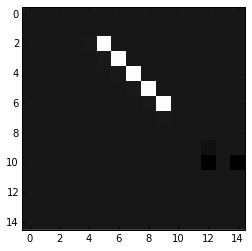

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
jmat = j(np.log(x0) if logC else x0)
plt.imshow(jmat, cmap='binary', interpolation='None')
jmat[:7, :4].tolist()

In [21]:
len(substances)

15

In [22]:
from scipy.optimize import root
x0 = [1]*len(substances)
root(f, x0, jac=j)

  status: 1
 success: True
     qtf: array([ -1.80115885e+03,   2.16393943e+01,  -8.10622018e+04,
         5.63927187e+12,  -8.62075028e+12,   2.00479626e+08,
         7.03406415e+08,   8.62981176e+10,   9.06405256e+05,
        -3.17536302e+05,  -1.08466885e+05,  -1.16791751e+05,
         5.79285219e+04,   4.87840290e+04,   6.14585183e+07])
    nfev: 4
       r: array([  5.00816365e+01,  -1.65645006e-02,   9.08269205e+01,
        -1.83396602e+00,   1.61553868e-09,  -1.99673986e-02,
        -3.99347972e-02,  -5.99021958e-02,  -7.98695944e-02,
        -9.98369931e-02,   1.32410958e-02,   1.31224758e-08,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -6.54109335e+01,  -2.30007813e-02,   4.64428949e-04,
        -2.04853332e-01,   5.05649389e-06,   1.01129878e-05,
         1.51694817e-05,   2.02259755e-05,   2.52824694e-05,
        -4.12015917e-02,  -3.05759281e-02,  -1.04662749e+01,
        -5.09319930e-02,   3.90207014e-02,  -2.19832695e+00,
        -1.24505219e+00, 

In [23]:
reaction_system.root(init_conc, scaling=scaling, logC=logC, delta=1e-15)

aqchem/equilibria.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  tot *= conc**nr
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(None,
   status: 5
 success: False
     qtf: array([ -3.25091247e+08,   2.55208735e+12,  -4.51184261e+07,
         1.05254776e+11,   1.76961872e+12,   3.86543415e+07,
         1.06408771e+11,  -9.82935450e+12,  -2.20067404e+08,
        -1.86186966e+04,  -7.92400745e+04,   1.18708443e+05,
         6.14451594e+07,   1.29470178e+06,   5.57507332e+03])
    nfev: 11
       r: array([ -1.79487046e+02,  -4.14603306e+15,   9.62999327e+01,
        -7.86090447e+11,  -1.25389677e+14,   1.13977450e+04,
         7.24448306e+14,   7.46554830e+20,   1.19114282e+23,
         2.97473602e+22,  -5.57143257e-03,  -1.04258769e-06,
        -7.26536818e+14,  -2.71642490e+09,   3.18837322e+23,
         3.26012002e+19,   1.22523040e-02,   6.17146790e+15,
         9.84413901e+17,  -8.94830010e+07,  -5.68760259e+18,
        -5.86108223e+24,  -9.35146807e+26,  -2.33541675e+26,
        -1.93188930e-06,   7.97383117e-03,   5.70596082e+18,
         2.13261285e+13,  -2.50352481e+27,  -1.13484629e+00,
        -1.0515

In [36]:
i = sp.symarray('i', len(y))
print(i)
reaction_system.f(y, i, scaling=s, reduced=True)

[i_0 i_1 i_2 i_3 i_4 i_5 i_6 i_7 i_8 i_9 i_10 i_11 i_12 i_13 i_14]


([-1.8018018018018e-16*s + (i_1*s + i_10*s + 2*i_11*s + 2*i_12*s + 3*i_13*s + 4*i_14*s - y10 - 2*y11 - 2*y12 - 3*y13 - 4*y14)*(i_0*s + i_10*s - i_3*s - i_5*s - 2*i_6*s - 3*i_7*s - 4*i_8*s - 5*i_9*s - y10 + y3 + y5 + 2*y6 + 3*y7 + 4*y8 + 5*y9)/y10,
  -5.49540873857625e-10*s + y3*(i_0*s + i_10*s - i_3*s - i_5*s - 2*i_6*s - 3*i_7*s - 4*i_8*s - 5*i_9*s - y10 + y3 + y5 + 2*y6 + 3*y7 + 4*y8 + 5*y9)/(i_2*s + i_3*s + i_5*s + 2*i_6*s + 3*i_7*s + 4*i_8*s + 5*i_9*s - y3 - y5 - 2*y6 - 3*y7 - 4*y8 - 5*y9),
  -19952.6231496888*s + y3*(2*i_11*s + i_12*s + i_13*s + i_14*s + i_4*s + i_5*s + i_6*s + i_7*s + i_8*s + i_9*s - 2*y11 - y12 - y13 - y14 - y5 - y6 - y7 - y8 - y9)/y5,
  -79432823.4724282*s**2 + y3**2*(2*i_11*s + i_12*s + i_13*s + i_14*s + i_4*s + i_5*s + i_6*s + i_7*s + i_8*s + i_9*s - 2*y11 - y12 - y13 - y14 - y5 - y6 - y7 - y8 - y9)/y6,
  -63095734448.0194*s**3 + y3**3*(2*i_11*s + i_12*s + i_13*s + i_14*s + i_4*s + i_5*s + i_6*s + i_7*s + i_8*s + i_9*s - 2*y11 - y12 - y13 - y14 - y5 - y6 - y7 

In [37]:
f_elim, j_elim, elim, elm_cbs = reaction_system.num_cb_factory(c0arr*scaling, True, scaling=scaling, logC=logC, reduced=True)
print(elim)

[0, 1, 2, 4]


In [38]:
c0arr_elim = np.array([x for idx, x in enumerate(c0arr) if idx not in elim]) + 1e-13
x0elim = np.log(c0arr_elim) if logC else c0arr_elim
f_elim(x0elim)

[5.5468955441440531e-22,
 -62507.525329639,
 99999980037.386826,
 99920567166.547546,
 36904265542.010567,
 -9900000000009.9609,
 -2411886431519.5303,
 -61459067.4568289,
 0.00099839125598603028,
 -2501886312.2538395,
 99982432505888.438]

array([  1.00000000e+00,   1.00000000e-13,   1.00000000e-13,
         1.00000000e-13,   1.00000000e-13,   1.00000000e-13,
         5.55000000e+01,   1.00000000e-13,   1.00000000e-13,
         1.00000000e-13,   1.00000000e-13])

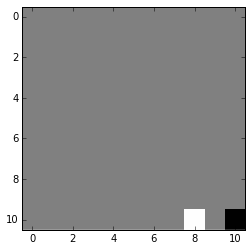

In [39]:
jmat = j_elim(x0elim)
plt.imshow(jmat, cmap='binary', interpolation='None')
x0elim

In [40]:
jmat

matrix([[  1.80178031e-09,   1.80178031e-09,   3.60356063e-09,
           5.40534094e-09,   7.20712126e-09,   9.00890157e-09,
          -3.60360915e-09,  -3.60365767e-09,  -3.60365767e-09,
          -5.40548651e-09,  -7.20731535e-09],
        [  3.90706959e+16,   3.90706959e+16,   7.81413919e+16,
           1.17212088e+17,   1.56282784e+17,   1.95353480e+17,
           6.25065875e+11,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00],
        [  1.00000000e+11,  -1.00000000e+24,  -1.00000000e+13,
          -1.00000000e+13,  -1.00000000e+13,  -1.00000000e+13,
           0.00000000e+00,  -2.00000000e+13,  -1.00000000e+13,
          -1.00000000e+13,  -1.00000000e+13],
        [  2.00000000e+11,  -1.00000000e+13,  -1.00000000e+24,
          -1.00000000e+13,  -1.00000000e+13,  -1.00000000e+13,
           0.00000000e+00,  -2.00000000e+13,  -1.00000000e+13,
          -1.00000000e+13,  -1.00000000e+13],
        [  3.00000000e+11,  -1.00000000e+13,  -1.00000000e+1

In [41]:
reaction_system.root(init_conc, scaling=1e8, init_iter=100)

(None,
   status: 5
 success: False
     qtf: array([ -2.13457346e+17,  -4.64182010e+19,  -1.53182466e+16,
         2.47603622e+52,  -2.10477532e+45,  -5.50630210e+16,
        -1.08444451e+38,   2.25890108e+36,  -2.03791778e+22,
         5.47861453e+21,  -5.07650064e+17,  -2.98461303e+16,
        -2.57056928e+16,   3.31381403e+14,  -1.12371182e+16])
    nfev: 25
       r: array([ -9.90849712e+01,  -3.64753563e-20,   7.19845293e-02,
         1.15725805e+08,  -4.04747757e+12,   1.00923479e-02,
         2.01846958e-02,   3.02770480e-02,   5.01682160e+08,
        -8.90887568e+21,  -1.00923479e-02,  -1.45391766e-34,
         1.09116595e-52,  -3.46672581e-68,  -6.27488864e-69,
         2.63551887e+03,   8.47032947e-22,  -8.97533902e+15,
        -3.49587137e+20,  -1.73472348e-18,   2.46614680e-15,
        -3.20103621e-02,  -2.39657070e+15,   3.33178551e+31,
         3.79431925e-04,   7.58863850e-04,   2.20998152e+09,
        -1.00766806e-02,   6.13442657e-04,  -1.00000026e+00,
         9.2199